**Seabird Audio Classifier**

This Seabird Audio Classifier has been adapted and further developed from the audio_classifier_tutorial.ipynb Colab notebook and the TensorFlow Simple Audio Classification tutorial.

**Authors**

The authors of this project are:

Dr Aline da Silva Cerqueira (King's College London and the ZSL Institute of Zoology)
Professor Terry Dawson (King's College London)
Dr Robin Freeman (The ZSL Institute of Zoology)

**Acknowledgements**

We sincerely value the hard work and dedication that went into the development of this automated seabird audio classifier. If you use or adapt this project, please ensure you credit the authors appropriately. Your acknowledgment supports the continued advancement of open-source tools in research and conservation. Thank you for your recognition and support!

**Technology**

**Colab Notebook**: Written in Python and TensorFlow. TensorFlow is an open-source software library for machine learning and artificial intelligence.

**Data Visualisation**: Utilises Seaborn, a Python data visualisation library built on Matplotlib, for creating statistical data visualisations.

**Purpose**

This project enables automated classification of seabird behaviours using acoustic data, providing researchers with an accessible, high-performing tool for ecological and conservation research.

**Setup and import necessary modules and dependencies**

In [ ]:
import os
import pathlib
import pandas

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

**Importing the Dataset**

Mount google drive and import files on google drive to a local sub-directory - '1sec'.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls /content/drive/MyDrive/1sec/


Mounted at /content/drive
flight	preening  vocals  water


In [ ]:
!ls /content/drive/MyDrive/1sec/


flight	preening  vocals  water


In [ ]:
DATASET_PATH = 'drive/MyDrive/1sec/'
data_dir = pathlib.Path(DATASET_PATH)
print(data_dir)

drive/MyDrive/1sec


In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
commands = [a for a in commands if not a.endswith('csv')]
commands = [a for a in commands if not a.endswith('gsheet')]
print('Commands:', commands)

Commands: ['water', 'flight', 'vocals', 'preening']


In [ ]:
# Extract the audio clips into a list called filenames, and shuffle it:

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 29586
Number of examples per label: 10152
Example file tensor: tf.Tensor(b'drive/MyDrive/1sec/vocals/WA1_F_120_sample_1.wav', shape=(), dtype=string)


In [ ]:
# Split filenames into training, validation and test sets using a 80:10:10 ratio, respectively:

train_files = filenames[:23668]
val_files = filenames[23668: 23668 + 2958]
test_files = filenames[-2958:]


print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 23668
Validation set size 2958
Test set size 2958


In this section you will preprocess the dataset, creating decoded tensors for the waveforms and the corresponding labels. Note that:

Each WAV file contains time-series data with a set number of samples per second.
Each sample represents the amplitude of the audio signal at that specific time.
In a 16-bit system, like the WAV files in the mini Speech Commands dataset, the amplitude values range from -32,768 to 32,767.
The sample rate for this dataset is 16kHz.
The shape of the tensor returned by tf.audio.decode_wav is [samples, channels], where channels is 1 for mono or 2 for stereo. The mini Speech Commands dataset only contains mono recordings

In [ ]:

!pip install tensorflow==2.8.0
import tensorflow as tf

!pip install tensorflow-io==0.25.0
### Need to 'restart runtime' after doing this the first time ###



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 KB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 104.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstalling tensorboard-2.11.2:
      Successfully uninstalled tensorboard-2.11.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.11.0
    Uninstalling tensorflow-2.11.0:
      Successfully uninstalled tensorflow-2.11.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.30.0
    Uninstalling tensorflow-io-gcs-filesystem-0.30.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.30.0


In [ ]:
#Test of the first sample in directories:
import tensorflow_io as tfio

#test_file = tf.io.read_file(DATASET_PATH+'/vocals/WA1_MB2_59.wav')
test_file = tf.io.read_file(DATASET_PATH+'/vocals/WA1_F_120_sample_1.wav')
test_audio, sample_rate = tf.audio.decode_wav(contents=test_file)

sample_rate = tf.cast(sample_rate, tf.int64)

audio = tfio.audio.resample(test_audio, sample_rate, 22050, name=None)

print(test_audio.shape)
print(audio.shape)

#if (audio.shape[1] > 1):
#  audio = audio[:, 1]
#  result = tf.squeeze(audio)
#else:
#  result = tf.squeeze(audio, axis=-1)

#bprint(result)




(44100, 1)
(22050, 1)


In [ ]:
# Now, let's define a function that preprocesses the dataset's raw WAV audio files into audio tensors:

def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, sample_rate = tf.audio.decode_wav(contents=audio_binary)
  #print(len(audio))
  sample_rate = tf.cast(sample_rate, tf.int64)
  #print(sample_rate)
  # Resample audio to 22KHz as we have a mix of 22 and 44KHz
  audio = tfio.audio.resample(
      audio, sample_rate, 22050, name=None
  )
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.

  return tf.squeeze(audio, axis=-1)

Version to decode mp3 files...

In [ ]:
#!pip install tensorflow-io==0.25

In [ ]:
import tensorflow_io as tfio

def decode_audio_mp3(audio_binary):
  # Decode MP3-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tfio.audio.decode_mp3(audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

Define a function that creates labels using the parent directories for each file:

Split the file paths into tf.RaggedTensors (tensors with ragged dimensions—with slices that may have different lengths).

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

Define another helper function—get_waveform_and_label—that puts it all together:

The input is the WAV audio filename.
The output is a tuple containing the audio and label tensors ready for supervised learning.

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  #waveform = tf.reshape(waveform, shape=(22050, 1, 1))

  return waveform, label

Build the training set to extract the audio-label pairs:

Create a tf.data.Dataset with Dataset.from_tensor_slices and Dataset.map, using get_waveform_and_label defined earlier.
We will build the validation and test sets using a similar procedure later on.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)



In [ ]:
for w, label in waveform_ds.take(2):
  print(w.shape)

(22050,)
(22050,)


In [ ]:
w.shape[0]

22050

0 tf.Tensor(b'vocals', shape=(), dtype=string)
1 tf.Tensor(b'preening', shape=(), dtype=string)
2 tf.Tensor(b'vocals', shape=(), dtype=string)
3 tf.Tensor(b'vocals', shape=(), dtype=string)
4 tf.Tensor(b'vocals', shape=(), dtype=string)
5 tf.Tensor(b'water', shape=(), dtype=string)
6 tf.Tensor(b'preening', shape=(), dtype=string)
7 tf.Tensor(b'flight', shape=(), dtype=string)
8 tf.Tensor(b'water', shape=(), dtype=string)


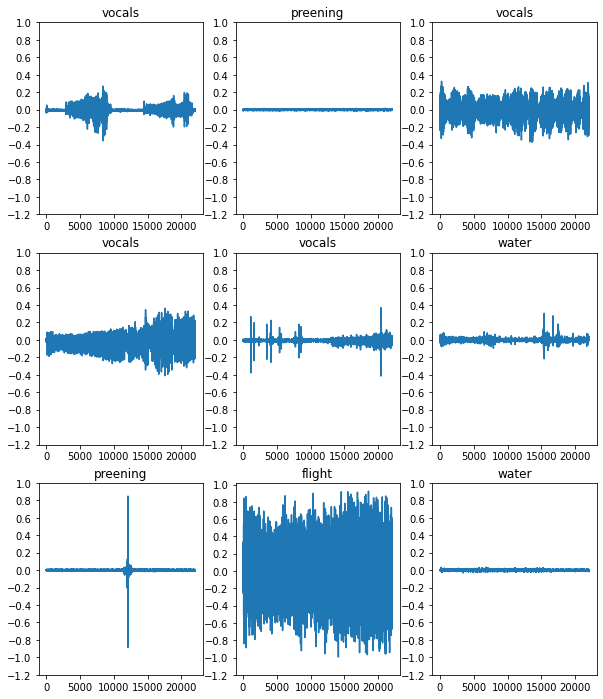

In [ ]:
# Let's plot a few audio waveforms:

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  print(i, label)
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

Convert waveforms to spectrograms
The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the short-time Fourier transform (STFT) to convert the waveforms to as spectrograms, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (tf.signal.fft) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (tf.signal.stft) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using tf.zeros).
When calling tf.signal.stft, choose the frame_length and frame_step parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to this Coursera video on audio signal processing and STFT.
The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying tf.abs on the output of tf.signal.stft.

In [ ]:
def get_spectrogram(waveform, input_len = 22050):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [input_len] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [ ]:
for waveform, label in waveform_ds.take(2):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform, waveform.shape[0])

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=22050))


Label: preening
Waveform shape: (22050,)
Spectrogram shape: (171, 129, 1)
Audio playback


In [ ]:
waveform

<tf.Tensor: shape=(22050,), dtype=float32, numpy=
array([-9.9720758e-08,  1.6543693e-07, -7.2781795e-08, ...,
       -2.3458770e-03, -5.3116530e-03, -4.5701889e-03], dtype=float32)>

In [ ]:
# Now, define a function for displaying a spectrogram:

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

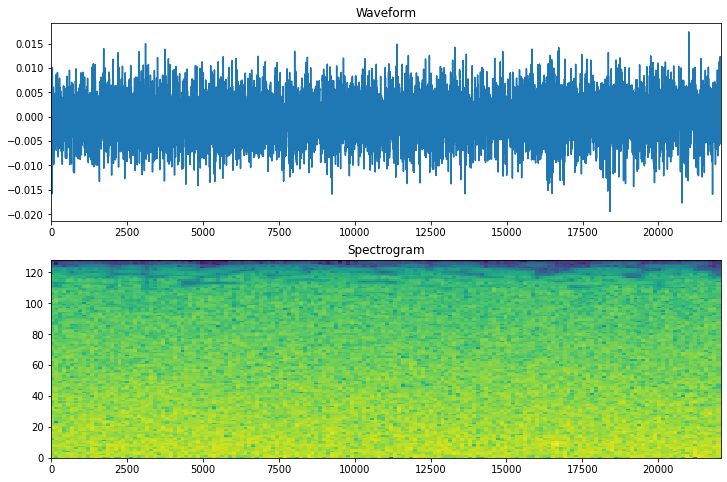

In [ ]:
# Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 22050])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

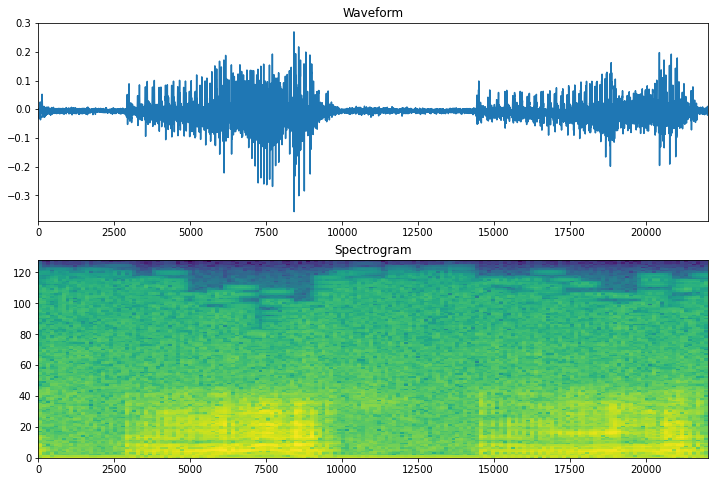

In [ ]:
audio_binary = tf.io.read_file(DATASET_PATH+'/vocals/WA1_F_120_sample_1.wav')

waveform = decode_audio(audio_binary)
spectrogram = get_spectrogram(waveform)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 22050])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
# Now, define a function that transforms the waveform dataset into spectrograms
# and their corresponding labels as integer IDs:

def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
# Map get_spectrogram_and_label_id across the dataset's elements with Dataset.map:

spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

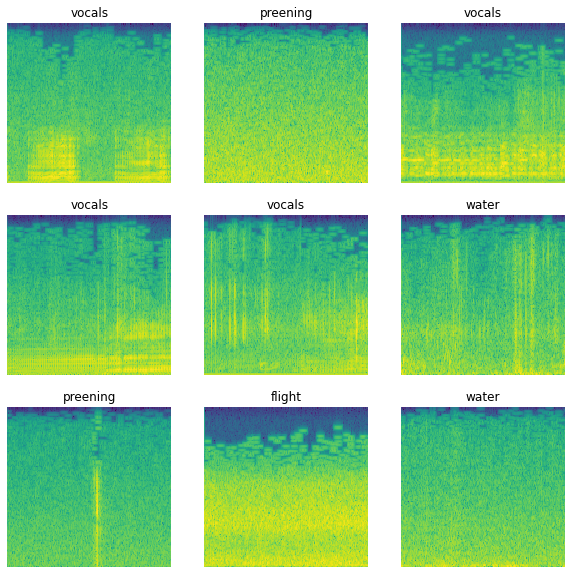

In [ ]:
# Examine the spectrograms for different examples of the dataset:

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

Build and train the model
Repeat the training set preprocessing on the validation and test sets

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

full_ds = preprocess_dataset(filenames)

In [ ]:
# Batch the training and validation sets for model training:

batch_size = 10
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
# Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model:

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, we'll use a simple convolutional neural network (CNN), since we have transformed the audio files into spectrogram images.

The tf.keras.Sequential model will use the following Keras preprocessing layers:

tf.keras.layers.Resizing: to downsample the input to enable the model to train faster.
tf.keras.layers.Normalization: to normalize each pixel in the image based on its mean and standard deviation.
For the Normalization layer, its adapt method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

Input shape: (171, 129, 1)


ValueError: ignored

In [ ]:
#

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [ ]:
# Configure the Keras model with the Adam optimizer and the cross-entropy loss:

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
# Train the model over 20 epochs for demonstration purposes:

EPOCHS = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

!mkdir -p /content/drive/MyDrive/saved_model

#with open('/content/drive/MyDrive/saved_model/albatross_model_nov_1sec_history', 'wb') as file_pi: pickle.dump(history.history, file_pi)
model.save('/content/drive/MyDrive/saved_model/albatross_model_nov_1sec')



Epoch 1/20
2367/2367 [==============================] - 9s 4ms/step - loss: 0.0877 - accuracy: 0.9684 - val_loss: 0.1729 - val_accuracy: 0.9483
Epoch 2/20
2367/2367 [==============================] - 9s 4ms/step - loss: 0.0883 - accuracy: 0.9676 - val_loss: 0.1952 - val_accuracy: 0.9466
Epoch 3/20
2367/2367 [==============================] - 9s 4ms/step - loss: 0.1151 - accuracy: 0.9675 - val_loss: 0.1872 - val_accuracy: 0.9479
Epoch 4/20
2367/2367 [==============================] - 9s 4ms/step - loss: 0.0795 - accuracy: 0.9711 - val_loss: 0.1903 - val_accuracy: 0.9523
Epoch 5/20
2367/2367 [==============================] - 9s 4ms/step - loss: 0.0803 - accuracy: 0.9709 - val_loss: 0.2462 - val_accuracy: 0.9557
Epoch 6/20
2367/2367 [==============================] - 9s 4ms/step - loss: 0.0725 - accuracy: 0.9743 - val_loss: 0.2094 - val_accuracy: 0.9530
Epoch 7/20
2367/2367 [==============================] - 9s 4ms/step - loss: 0.0869 - accuracy: 0.9710 - val_loss: 0.2145 - val_accuracy:

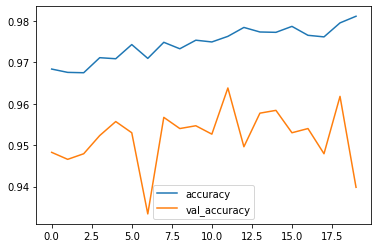

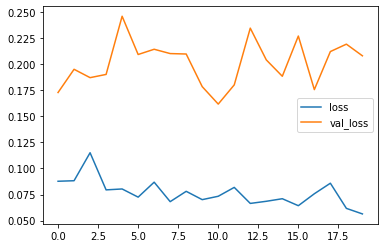

In [ ]:
# Let's plot the training and validation loss curves to check how the model has improved during training:

metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Evaluate the model performance
Run the model on the test set and check the model's performance:

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)


In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 97%


Display a confusion matrix
Use a confusion matrix to check how well the model did classifying each of the commands in the test set:

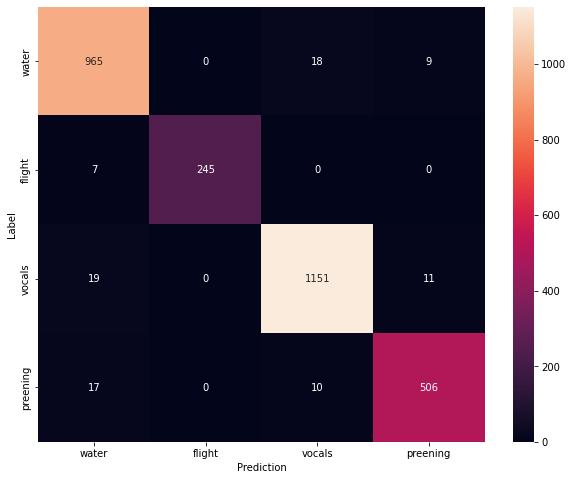

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

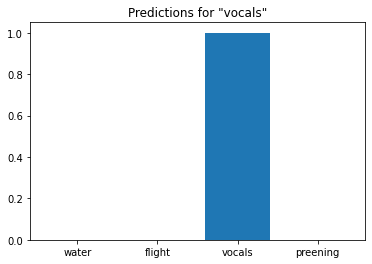

In [ ]:
# Run inference on an audio file
# Finally, verify the model's prediction output using an example audio file. How well does the model perform?

sample_file = DATASET_PATH+'/vocals/WA1_F_1_sample_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

In [ ]:
#Output a spreadsheet using the model.predict function:

#predictions = model.predict(test_audio)
#preds = pd.DataFrame(predictions)
#preds.to_csv('drive/MyDrive/10s/' + 'predictions.csv')


In [ ]:
#This will output a csv file with the SoftMax score for each of classes & include columns with the predicted and true class:

predictions = model.predict(test_audio)

y_pred = np.argmax(predictions, axis=1)
#y_true = test_labels

preds = pd.DataFrame(tf.nn.softmax(predictions))
preds['known_label'] = test_labels # Might work
preds['known_label_name'] = np.array(commands)[test_labels] # Might work
preds['filename'] = test_files # Might work
preds['prediction'] = y_pred
preds['prediction_name'] = np.array(commands)[y_pred] # Might work
preds.to_csv('drive/MyDrive/' + 'predictions_1sec_100E.csv')


In [ ]:
#For predicted and true class:

#output = pd.DataFrame(list(zip(test_labels, y_pred)), columns=['true_label',   'prediction'])
#output.to_csv('drive/MyDrive/10s/' + 'predictions.csv')


Apply trained model to *all* data

In [ ]:
full_audio = []
full_labels = []

for audio, label in full_ds:
  full_audio.append(audio.numpy())
  full_labels.append(label.numpy())

full_audio = np.array(full_audio)
full_labels = np.array(full_labels)

full_predictions = model.predict(full_audio)

full_y_pred = np.argmax(full_predictions, axis=1)
#y_true = test_labels

full_preds = pd.DataFrame(tf.nn.softmax(full_predictions))
full_preds['known_label'] = full_labels # Might work
full_preds['known_label_name'] = np.array(commands)[full_labels] # Might work
full_preds['filename'] = filenames # Might work
full_preds['prediction'] = full_y_pred
full_preds['prediction_name'] = np.array(commands)[full_y_pred] # Might work
full_preds.to_csv('drive/MyDrive/' + 'full_predictions_1sec.csv')




In [ ]:
full_audio.shape

(29586, 171, 129, 1)

Run predictions on single file....

In [ ]:
!ls drive/MyDrive/at_sea_albatross/Y212_BBA2/

Y212_BBA2_R-002.MP3  Y212_BBA2_R-005.MP3  Y212_BBA2_R-008.MP3
Y212_BBA2_R-003.MP3  Y212_BBA2_R-006.MP3
Y212_BBA2_R-004.MP3  Y212_BBA2_R-007.MP3


In [ ]:
def split_wav(fname):
    audio_binary = tf.io.read_file(fname)
    wav = decode_audio(audio_binary) # Returns tf.float32 tensor
     # Slice 22050 length splits and drop remaining
    n = int(tf.size(wav) / NUM_SAMPLES)
    audio = wav[:(n * NUM_SAMPLES)]
    x = tf.reshape(tensor=audio, shape=(n, NUM_SAMPLES)) # Reshape along batch dim
    return x

NUM_SAMPLES = 22050

# Name of the file to process
fname = 'drive/MyDrive/at_sea_albatross/Y212_BBA2/Y212_BBA2_R-003.MP3/'

dat = split_wav(fname)
dat = tf.data.Dataset.from_tensor_slices(dat)

# Make spectrograms of each snippet
pred_data = []
for d in dat:
  spectrogram = get_spectrogram(d)
  pred_data.append(spectrogram.numpy())

pred_data = np.array(pred_data)

#Run predictions on spectrograms in pred_data
dat_predictions = model.predict(pred_data)

dat_y_pred = np.argmax(dat_predictions, axis=1)
#y_true = test_labels

# Turn model outputs into probabilities
p_pred = tf.nn.softmax(dat_predictions).numpy()

# Calculate start times at each n*NUM_SAMPLES
start_times = range(1, NUM_SAMPLES*len(p_pred), NUM_SAMPLES)

# Put everything in a dataframe and save to file
dat_preds = pd.DataFrame(p_pred)
dat_preds['prediction'] = dat_y_pred
dat_preds['filename'] = np.repeat(fname, len(p_pred))
dat_preds['start_times'] = start_times
dat_preds['prediction_name'] = np.array(commands)[dat_y_pred] # Might work
# Save to file with the same name as fname, but with _predictions.csv on the end
dat_preds.to_csv(DATASET_PATH + os.path.basename(fname).replace(".wav", "_predictions.csv"))

UnicodeDecodeError: ignored

In [ ]:
dat_preds

NameError: ignored

Run predictions on mp3 files....

In [ ]:
!pip uninstall tensorflow
!pip uninstall tensorflow-io
!pip install tensorflow-gpu
!pip install --no-deps tensorflow-io

In [ ]:
def split_mp3(fname):
    #audio_binary = tf.io.read_file(fname)
    #mp3 = decode_audio_mp3(fname) # Returns tf.float32 tensor
    audio = tfio.audio.decode_mp3(fname)
    mp3 = tf.squeeze(audio, axis=-1)
     # Slice 22050 length splits and drop remaining
    n = int(tf.size(mp3) / NUM_SAMPLES)
    audio = mp3[:(n * NUM_SAMPLES)]
    x = tf.reshape(tensor=audio, shape=(n, NUM_SAMPLES)) # Reshape along batch dim
    return x

NUM_SAMPLES = 22050

for f in os.listdir("/content/drive/MyDrive/files_to_process/"):
  # Do stuff here
  # Name of the file to process
  print(f)
  dat = split_mp3("/content/drive/MyDrive/files_to_process/" + f )
  dat = tf.data.Dataset.from_tensor_slices(dat)
  # Make spectrograms of each snippet
  pred_data = []
  for d in dat:
    spectrogram = get_spectrogram(d)
    pred_data.append(spectrogram.numpy())

  pred_data = np.array(pred_data)

  #Run predictions on spectrograms in pred_data
  dat_predictions = model.predict(pred_data)

  dat_y_pred = np.argmax(dat_predictions, axis=1)
  #y_true = test_labels

  # Turn model outputs into probabilities
  p_pred = tf.nn.softmax(dat_predictions).numpy()

  # Calculate start times at each n*NUM_SAMPLES
  start_times = range(1, NUM_SAMPLES*len(p_pred), NUM_SAMPLES)

  # Put everything in a dataframe and save to file
  dat_preds = pd.DataFrame(p_pred)
  dat_preds['prediction'] = dat_y_pred
  dat_preds['filename'] = np.repeat(f, len(p_pred))
  dat_preds['start_times'] = start_times
  dat_preds['prediction_name'] = np.array(commands)[dat_y_pred] # Might work
  # Save to file with the same name as f, but with _predictions.csv on the end
  dat_preds.to_csv("/content/drive/MyDrive/file_predictions/" + os.path.basename(f).replace(".wav", "_predictions.csv"))

R-006.MP3


InvalidArgumentError: ignored

In [ ]:
dat_preds

,0,1,2,3,4,5,6,7,prediction,filename,start_times,prediction_name
0,0.000002,5.833842e-12,3.169252e-12,2.001787e-12,0.999998,3.893763e-10,1.525123e-08,1.767996e-09,4,drive/MyDrive/10s//wa_vocals/WA1_F_109.wav,1,wa_vocals
1,0.092712,6.336881e-05,1.236318e-05,1.320165e-04,0.902763,7.070849e-04,1.442457e-04,3.466149e-03,4,drive/MyDrive/10s//wa_vocals/WA1_F_109.wav,44101,wa_vocals
2,0.413948,8.304036e-06,1.149964e-05,7.656770e-05,0.564218,1.513213e-05,1.538564e-04,2.156898e-02,4,drive/MyDrive/10s//wa_vocals/WA1_F_109.wav,88201,wa_vocals
3,0.417071,8.789435e-05,1.651262e-04,2.219945e-03,0.537844,1.459466e-04,2.352247e-04,4.223031e-02,4,drive/MyDrive/10s//wa_vocals/WA1_F_109.wav,132301,wa_vocals
4,0.007020,1.017317e-08,3.465601e-09,3.429159e-06,0.992834,1.186237e-06,1.535191e-08,1.415500e-04,4,drive/MyDrive/10s//wa_vocals/WA1_F_109.wav,176401,wa_vocals
5,0.004686,1.347895e-08,7.394232e-08,3.351159e-06,0.995238,4.116089e-07,1.378564e-06,7.064538e-05,4,drive/MyDrive/10s//wa_vocals/WA1_F_109.wav,220501,wa_vocals
6,0.426203,1.836768e-06,6.438507e-07,3.892108e-04,0.570002,1.248479e-04,2.152288e-07,3.278248e-03,4,drive/MyDrive/10s//wa_vocals/WA1_F_109.wav,264601,wa_vocals
7,0.084846,3.376812e-09,9.733622e-11,4.077327e-08,0.915139,3.639572e-07,4.259566e-09,1.497163e-05,4,drive/MyDrive/10s//wa_vocals/WA1_F_109.wav,308701,wa_vocals
8,0.002417,1.146804e-10,7.880875e-13,1.068256e-10,0.997583,8.228085e-08,5.476271e-11,1.041229e-07,4,drive/MyDrive/10s//wa_vocals/WA1_F_109.wav,352801,wa_vocals
9,0.008533,8.664177e-10,4.116999e-11,3.602350e-09,0.991464,5.393907e-07,4.190827e-09,1.758578e-06,4,drive/MyDrive/10s//wa_vocals/WA1_F_109.wav,396901,wa_vocals
